# 1. APP Loading

## 1.0. Open Database

In [25]:
import requests
import pandas as pd
import sqlite3
import tqdm
import requests as rq
from bs4 import BeautifulSoup
from io import BytesIO
import re
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"
import myAPI_keys as Key
import db.init_db as init_db


init_db.init_entire_database()
print("Database initilized! load data from API and insert into database...")


conn = sqlite3.connect("db/StockManageAPP.sqlite")

cur = conn.cursor()

Database initilized! load data from API and insert into database...


/Users/jiho/Desktop/DB_API_assignment/db/init_db.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[1] = str(row[1]).zfill(6)
/Users/jiho/Desktop/DB_API_assignment/db/init_db.py:55: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[1] = str(row[1]).zfill(6)


## 1.1. Update [StockInfo] Table

### 1.1.1. Defince Function : Get_Stock_Price 
- 한국증권거래소 API에 종목코드를 파라미터로 이용해, 종목명과 종가 가져옴.

In [26]:
def Get_Stock_Info():
    endpoint = "http://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo"
    url = f"{endpoint}?pageNo={1}&resultType=json&numOfRows={3000}&serviceKey={Key.STOCK_INFO_ENCODED_KEY}"
    response = requests.get(url).json().get("response").get("body").get("items")
    return response

### 1.1.2. [StockInfo Table(df)] 초기 형태 제작
- 금융결제원 API로 불러온 정보를 마지막 검색일자인 정보만 남김.
- 이후 StockInfo의 형태로 df를 제작

In [27]:
_ans = Get_Stock_Info()
df = pd.DataFrame(_ans.get("item"))[["srtnCd", "itmsNm", "mrktCtg", "clpr", "basDt"]]
last_date = df["basDt"].max()
df = df[df["basDt"] == last_date]
########################################################################
df = pd.DataFrame(df)[["srtnCd", "itmsNm", "mrktCtg", "clpr"]]
df = df.rename(
    columns={
        "srtnCd": "StockCode",
        "itmsNm": "StockName",
        "mrktCtg": "Category",
        "clpr": "Price",
    }
)
df = df.drop(df[df["Category"] == "KONEX"].index)

In [28]:
df

,StockCode,StockName,Category,Price
0,900110,이스트아시아홀딩스,KOSDAQ,118
1,900270,헝셩그룹,KOSDAQ,215
2,900260,로스웰,KOSDAQ,752
3,900290,GRT,KOSDAQ,2720
4,900300,오가닉티코스메틱,KOSDAQ,123
...,...,...,...,...
2780,900120,씨엑스아이,KOSDAQ,112
2781,900250,크리스탈신소재,KOSDAQ,1575
2782,900070,글로벌에스엠,KOSDAQ,561
2783,900140,엘브이엠씨홀딩스,KOSPI,2385


### 1.1.2. load category table (in memory)
- http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020502
- KRX에서 업종정보 포함한 종합 정보 csv file 다운 후, 메모리에 불러옴
- 해당 사이트의 API를 이용하기 위해선, 사업자등록번호가 필요하기 때문에 불가피하게 csv file을 다운받아서 사용함.

In [29]:
# Load the two CSV files with 'euc-kr' encoding
df1 = pd.read_csv("db/doc/data_2239_20231121.csv", encoding="euc-kr")
df2 = pd.read_csv("db/doc/data_2303_20231121.csv", encoding="euc-kr")

# Concatenate the two DataFrames
df3 = pd.concat([df1, df2])

# If you want to reset the index
krx_sector = df3.reset_index(drop=True)

In [30]:
krx_sector

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,095570,AJ네트웍스,KOSPI,서비스업,4165,15,0.36,188477741235
1,006840,AK홀딩스,KOSPI,기타금융,17980,-20,-0.11,238191146780
2,027410,BGF,KOSPI,기타금융,3570,30,0.85,341708943870
3,282330,BGF리테일,KOSPI,유통업,135400,1900,1.42,2340240872400
4,138930,BNK금융지주,KOSPI,기타금융,7100,30,0.42,2286827909800
...,...,...,...,...,...,...,...,...
2642,024060,흥구석유,KOSDAQ,유통,8710,340,4.06,130650000000
2643,010240,흥국,KOSDAQ,기계·장비,5900,50,0.85,72703906400
2644,189980,흥국에프엔비,KOSDAQ,음식료·담배,2090,40,1.95,83888058430
2645,037440,희림,KOSDAQ,기타서비스,8280,220,2.73,115278093000


### 1.1.3. Add Stock{Name, Price} to [StockInfo(df)] by using API

In [31]:
for _StockCode in tqdm.tqdm(df["StockCode"].tolist()):
    # Find the matching row in krx_sector
    matching_sector = krx_sector[krx_sector["종목코드"] == _StockCode]["업종명"]
    if len(matching_sector) == 0:
        continue
    df.loc[df["StockCode"] == _StockCode, "Category"] = matching_sector.values[0]

100%|██████████| 2656/2656 [00:00<00:00, 3066.68it/s]


In [32]:
# 2776개에 2647개의 업종명이 매칭되었는데, 나머지 129개는 시장명으로 되어있는 상태. 어떻게 해야할 지 모르겠음.
df

,StockCode,StockName,Category,Price
0,900110,이스트아시아홀딩스,금융,118
1,900270,헝셩그룹,금융,215
2,900260,로스웰,금융,752
3,900290,GRT,금융,2720
4,900300,오가닉티코스메틱,금융,123
...,...,...,...,...
2780,900120,씨엑스아이,금융,112
2781,900250,크리스탈신소재,금융,1575
2782,900070,글로벌에스엠,금융,561
2783,900140,엘브이엠씨홀딩스,유통업,2385


### 1.1.4. 만든 df Table을 [StockInfo table]에 대입

In [33]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Create the INSERT statement
    sql = f"""
    INSERT INTO StockInfo (StockCode, StockName, Price, Category)
    VALUES ('{row['StockCode']}', '{row['StockName']}', {row['Price']}, '{row['Category']}')
    """

    # Execute the INSERT statement
    cur.execute(sql)

# Commit the changes and close the connection
conn.commit()

## 1.2. Update [UserInfo] Table 
- Update a [UserInfo].Blance
- Update a [UserInfo].FavoriteCategory

### 1.2.1 Update [UserInfo].Blance

In [34]:
sql = f"""
    SELECT ID, SUM(Count * Price) as TotalValue
    FROM (
        SELECT IndividualStockAcount.ID, IndividualStockAcount.StockCode, IndividualStockAcount.Count, StockInfo.Price
        FROM IndividualStockAcount
        JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
    )
    GROUP BY ID
    """

df = pd.read_sql_query(sql, conn)

In [35]:
df

,ID,TotalValue
0,hoho222,1296036
1,hseop884,4174500
2,jiho264,914035
3,jitae19,226620
4,kimlee121,46174
5,nick0422,1237905
6,taeji19,120350
7,user270,500920
8,xotn531,1133632


In [36]:
# Write the DataFrame to a temporary table in the SQLite database
df.to_sql("temp", conn, if_exists="replace", index=False)

# Update the UserInfo table based on the temporary table
cur.execute(
    """
    UPDATE UserInfo
    SET Balance = (
        SELECT TotalValue
        FROM temp
        WHERE temp.ID = UserInfo.ID
    )
    WHERE EXISTS (
        SELECT 1
        FROM temp
        WHERE temp.ID = UserInfo.ID
    )
"""
)
cur.execute("DROP TABLE IF EXISTS temp")

conn.commit()

### 1.2.2. [IndividualStockAccount].TotalPrice

In [37]:
sql = f"""
    SELECT IndividualStockAcount.ID, IndividualStockAcount.StockCode, IndividualStockAcount.Count, StockInfo.Price
    FROM IndividualStockAcount
    JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
    """

df = pd.read_sql_query(sql, conn)

In [38]:
df

,ID,StockCode,Count,Price
0,hoho222,005930,3,71200
1,nick0422,035420,4,213000
2,jiho264,000660,5,125900
3,hoho222,000660,5,125900
4,user270,000660,1,125900
5,user270,005930,1,71200
6,user270,035420,1,213000
7,hseop884,086520,4,658000
8,hseop884,247540,5,308500
9,hoho222,009150,1,145300


In [39]:
# Write the DataFrame to a temporary table in the SQLite database
df.to_sql("temp", conn, if_exists="replace", index=False)

# Update the individualstockaccount table based on the temporary table
cur.execute(
    """
    UPDATE IndividualStockAcount
    SET TotalPrice = (
        SELECT Count * Price
        FROM temp
        WHERE temp.ID = IndividualStockAcount.ID AND temp.StockCode = IndividualStockAcount.StockCode
    )
    WHERE EXISTS (
        SELECT 1
        FROM temp
        WHERE temp.ID = IndividualStockAcount.ID AND temp.StockCode = IndividualStockAcount.StockCode
    )
"""
)
cur.execute("DROP TABLE IF EXISTS temp")
conn.commit()

### 1.2.3. Update the [UserInfo].FavCategory column
- 각 Id마다의 Category별 TotalPrice합계를 구하고, 가장 큰 Category를 FavoriteCategory로 지정

In [40]:
# Get the category with the highest sum of TotalPrice for each ID
sql = """
SELECT IndividualStockAcount.ID, StockInfo.Category, SUM(IndividualStockAcount.TotalPrice) as Total
FROM UserInfo
LEFT JOIN IndividualStockAcount ON UserInfo.ID = IndividualStockAcount.ID
LEFT JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
GROUP BY IndividualStockAcount.ID, StockInfo.Category
"""

df = pd.read_sql_query(sql, conn)

# Find the category with the highest sum of TotalPrice for each ID
df = df.loc[df.groupby("ID")["Total"].idxmax()]

# Update the UserInfo table with the FavCategory
for index, row in df.iterrows():
    sql = f"""
    UPDATE UserInfo
    SET FavCategory = '{row['Category']}' 
    WHERE ID = '{row['ID']}'
    """
    cur.execute(sql)

conn.commit()

In [41]:
df

,ID,Category,Total
7,hoho222,전기전자,1012320
9,hseop884,금융,2632000
16,jiho264,전기전자,653150
19,jitae19,IT부품,111600
24,kimlee121,화학,37165
28,nick0422,서비스업,852000
34,taeji19,제약,63200
38,user270,서비스업,234700
47,xotn531,전기전자,712000


## 1.3. Update [IndividualStockAccount] Table

In [42]:
# Update the IndividualStockAcount table with the StockName based on the StockCode
cur.execute(
    """
UPDATE IndividualStockAcount
SET StockName = (
    SELECT StockName
    FROM StockInfo
    WHERE StockInfo.StockCode = IndividualStockAcount.StockCode
)
"""
)

# Commit the changes
conn.commit()

# 2. APP Running

## 2.1. Login

In [43]:
USER_ID = "jiho264"
USER_PW = "admin"

In [44]:
def Circle_Plot(df, values, names, title, is_million=False):
    """
    input : 
        - df : data 전체가 들은 dataframe
        - values : 표시할 값
        - names : 표시할 값의 이름
        - title : plot의 제목
        - is_million=False : 출력 금액 단위. 기본 만 원단위.
    output : show the Circle Plot
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the circle plo
    if is_million == False:
        wedges, texts, autotexts = ax.pie(
            df[values],
            labels=[
                f"{name}\n({round(value/10000)}만 원)"
                for name, value in zip(df[names], df[values])
            ],
            autopct="%1.1f%%",
        )
    else:
        wedges, texts, autotexts = ax.pie(
            df[values],
            labels=[
                f"{name}\n({round(value/10000, 2)}조 원)"
                for name, value in zip(df[names], df[values])
            ],
            autopct="%1.1f%%",
        )
    # Set the aspect ratio to be equal so that the pie is drawn as a circle
    ax.set_aspect("equal")

    # Set the title of the plot
    ax.set_title(title)

    # Show the plot
    plt.show()

## 2.2. Statistics of StockInfo about MyPage

-----------------------------------------------------------------
Hello, jiho264!
-----------------------------------------------------------------
Your Stock Account is :
  StockCode StockName  Count  TotalPrice
0    000430      대원강업      5       25100
1    000660    SK하이닉스      5      629500
2    005710      대원산업      2       11380
3    005960      동부건설      6       36660
4    023910      대한약품      5      138750
5    048470      대동스틸      5       17475
6    263600      덕우전자      4       31520
7    336370   솔루스첨단소재      1       23650
-----------------------------------------------------------------
Your Favorite Category is : 전기전자
-----------------------------------------------------------------
Your Budget is :
   Balance  Deposit
0   914035    15564
Your Sum of Assets is :  929599
-----------------------------------------------------------------


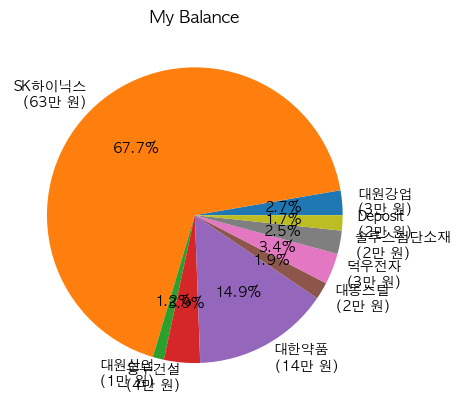

In [45]:
class Logined_User:
    """

    usage : user = Logined_User(conn, USER_ID, USER_PW)
    input :
        - conn : sqlite3.connect()로 생성한 connection
        - USER_ID : 사용자 ID
        - USER_PW : 사용자 PW
    function :
        - login() : 로그인. 해당 ID와 PW가 UserInfo에 있는지 확인하고, 있으면 로그인 성공, 없으면 로그인 실패.
            -- self.UserInfo.Balance = 주식총액
            -- self.UserInfo.Deposit = 예수금
        - call_stock_account() : 해당 ID의 주식 계좌를 출력.
        - call_budget() : 해당 ID의 주식 평가금액 (Balance)과 예수금(Deposit)을 출력.
        - plot_account() : 해당 ID의 전체 자산을 원형 그래프로 출력. (Balance + Deposit)
    """

    def __init__(self, _conn, _id, _pw):
        self.f_plot = Circle_Plot
        self.ID = _id
        self.PW = _pw
        self.conn = _conn

    def printendline(self):
        print("-----------------------------------------------------------------")
        return

    def login(self):
        self.printendline()
        _sql = (
            f""" SELECT * FROM UserInfo WHERE ID = '{self.ID}' AND PW = '{self.PW}'"""
        )
        self.UserInfo = pd.read_sql_query(_sql, self.conn)
        if self.UserInfo.empty == True:
            print("ID or PW is wrong!")
        else:
            print("Hello, " + self.ID + "!")
        return

    def call_stock_account(self, _show=False):
        self.printendline()
        print("Your Stock Account is :")
        _sql = f"""
        SELECT StockCode, StockName, Count, TotalPrice
        FROM IndividualStockAcount
        WHERE ID = '{self.ID}'
        """

        self.StockInfo = pd.read_sql_query(_sql, self.conn)
        print(self.StockInfo)
        self.printendline()
        print("Your Favorite Category is :", self.UserInfo["FavCategory"].values[0])

        return self.StockInfo

    def call_budget(self):
        self.printendline()
        print("Your Budget is :")
        _sql = f"""
        SELECT Balance, Deposit
        FROM UserInfo
        WHERE ID = '{self.ID}'
        """

        self.Balance = pd.read_sql_query(_sql, self.conn)
        print(self.Balance)
        print("Your Sum of Assets is : ", self.Balance.values[0][0] + self.Balance.values[0][1])
        return self.Balance

    def plot_account(self):
        self.printendline()

        if "000000" not in self.StockInfo["StockCode"].values:
            _new_row = {
                # "ID": self.ID,
                "StockCode": "000000",
                "StockName": "Deposit",
                "Count": 1,
                "TotalPrice": self.Balance.values[0][1],
            }
            _the_account_include_deposit_ = pd.concat(
                [self.StockInfo, pd.DataFrame([_new_row])],
                ignore_index=True,
            )
        self.f_plot(
            _the_account_include_deposit_, "TotalPrice", "StockName", "My Balance"
        )
        return None


user = Logined_User(conn, USER_ID, USER_PW)
user.login()
user.call_stock_account()
user.call_budget()
user.plot_account()

## 2.3. Statistics of StockInfo about All Users
- 전체 증권사 회원들의 투자분표를 시각화해, 시장에 대한 개인의 대응을 보여줌

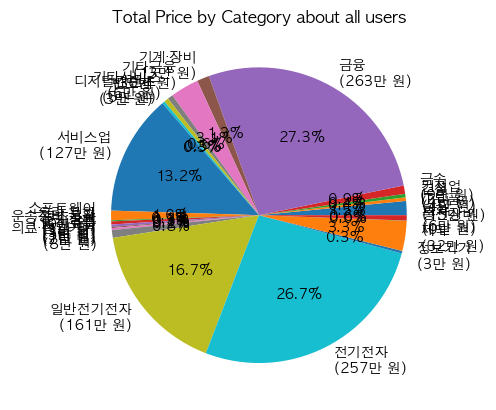

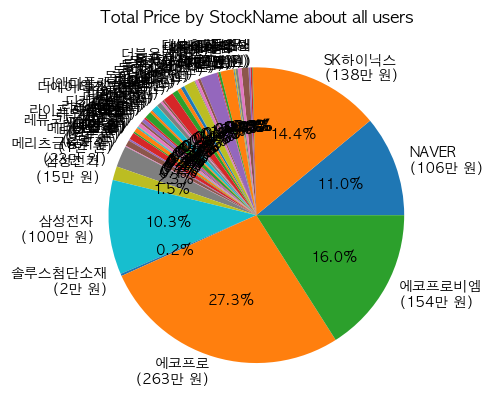

In [46]:
class Trand_of_Users:
    def __init__(self, _conn):
        self.conn = _conn
        self.f_plot = Circle_Plot
        sql = """
        SELECT StockInfo.Category, IndividualStockAcount.StockName, SUM(IndividualStockAcount.Count) as TotalCount, SUM(IndividualStockAcount.TotalPrice) as TotalPrice
        FROM IndividualStockAcount
        JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
        GROUP BY StockInfo.Category, IndividualStockAcount.StockName
        """

        self.trand = pd.read_sql_query(sql, conn)

    def plot_totalprice_of_category(self):
        _tmp = self.trand.groupby("Category").agg({"TotalPrice": "sum"}).reset_index()
        Circle_Plot(
            _tmp,
            "TotalPrice",
            "Category",
            "Total Price by Category about all users",
        )
        return None

    def plot_totalprice_of_stockname(self):
        _tmp = self.trand.groupby("StockName").agg({"TotalPrice": "sum"}).reset_index()

        Circle_Plot(
            _tmp,
            "TotalPrice",
            "StockName",
            "Total Price by StockName about all users",
        )
        return None


_summary_info_of_all_users = Trand_of_Users(conn)
_summary_info_of_all_users.plot_totalprice_of_category()
_summary_info_of_all_users.plot_totalprice_of_stockname()

## 2.4. The stock which the USER do not bought in same category

In [63]:
class find_that_what_i_did_not_bought:
    def __init__(self, _conn, _id):
        self.conn = _conn
        self.ID = _id

        print("I am : " + self.ID)

    def find_same_favcategory_users(self):
        _sql = f"""
        SELECT ID, FavCategory FROM UserInfo
        WHERE FavCategory = (
            SELECT FavCategory
            FROM UserInfo
            WHERE ID = '{self.ID}'
        ) AND ID != '{self.ID}'
        """
        self.other_users = pd.read_sql_query(_sql, self.conn)
        self.FavCategory = self.other_users["FavCategory"].values[0]

        print("My FavCategory is : ", self.FavCategory)
        print("-----------------------------------------------------------------")

        ## 개인정보지만, 디버깅을 위해서 확인하는 중.
        print("I have same FavCategory with : ")
        print(self.other_users)
        return self.other_users

    def find_i_did_not_bought(self):
        _sql = f"""
        SELECT IndividualStockAcount.StockName
        FROM IndividualStockAcount
        WHERE IndividualStockAcount.ID IN (
            SELECT ID
            FROM UserInfo
            WHERE FavCategory = (
                SELECT FavCategory
                FROM UserInfo
                WHERE ID = '{self.ID}'
            )
            AND ID != '{self.ID}'
        )
        AND IndividualStockAcount.StockName NOT IN (
            SELECT StockName
            FROM IndividualStockAcount
            WHERE ID = '{self.ID}'
        )
        """
        self.not_have = pd.read_sql_query(_sql, self.conn)

        return self.not_have

    def not_bought_stock_info(self):
        self.not_have = self.find_i_did_not_bought()
        print("-----------------------------------------------------------------")
        # Find the stock information for the stocks in not_bought_stocks

        self.not_have.to_sql("temp", self.conn, if_exists="replace", index=False)

        _sql = f"""
        SELECT StockInfo.StockName, StockInfo.Price, StockInfo.Category
        FROM StockInfo, temp
        WHERE StockInfo.StockName = temp.StockName AND StockInfo.Category = '{self.FavCategory}'

        """
        self.not_bought_stock_info = pd.read_sql_query(_sql, self.conn)
        print("I did not bought : ")
        print(self.not_bought_stock_info)
        self.conn.execute("DROP TABLE IF EXISTS temp")
        self.conn.commit()

        return self.not_bought_stock_info


print("-----------------------------------------------------------------")
_result = find_that_what_i_did_not_bought(conn, USER_ID)
_result.find_same_favcategory_users()
# _result.find_i_did_not_bought()
_result.not_bought_stock_info()
print("-----------------------------------------------------------------")

-----------------------------------------------------------------
I am : jiho264
My FavCategory is :  전기전자
-----------------------------------------------------------------
I have same FavCategory with : 
        ID FavCategory
0  hoho222        전기전자
1  xotn531        전기전자
-----------------------------------------------------------------
I did not bought : 
  StockName   Price Category
0      대한전선   11960     전기전자
1      삼성전자   71200     전기전자
2      삼성전자   71200     전기전자
3      삼성전기  145300     전기전자
-----------------------------------------------------------------


## 2.5 국민 연금과의 비교 시각화
- 국민연금공단의 포트폴리오를 시각화하며, 본인과 얼마나 다른지 비교함으로써, 자신의 포트폴리오가 얼마나 안정적인지 확인할 수 있습니다.
- 국민연금공단_국내주식 투자정보_20221231

-----------------------------------------------------------------
NPS Account Top 10 : 


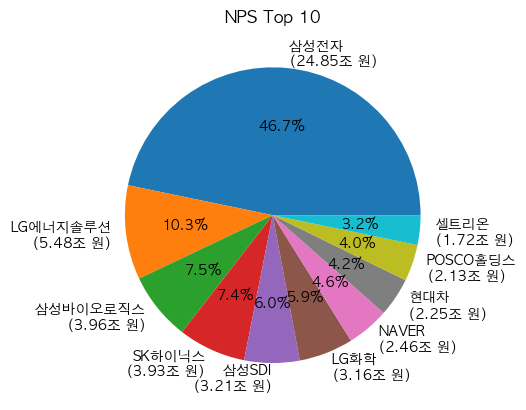

-----------------------------------------------------------------
Your Stock Account is :
  StockCode StockName  Count  TotalPrice
0    000430      대원강업      5       25100
1    000660    SK하이닉스      5      629500
2    005710      대원산업      2       11380
3    005960      동부건설      6       36660
4    023910      대한약품      5      138750
5    048470      대동스틸      5       17475
6    263600      덕우전자      4       31520
7    336370   솔루스첨단소재      1       23650
-----------------------------------------------------------------
Your Favorite Category is : 전기전자
Missing Stocks : 
-----------------------------------------------------------------


In [77]:
class Nps_account:
    def __init__(self):
        self.url = f"https://api.odcloud.kr/api/3070507/v1/uddi:c3ae1435-165c-42f4-bf8d-cc26f68e71f6?page=1&perPage=1500&serviceKey={Key.STOCK_INFO_ENCODED_KEY}"  # Replace with the actual API endpoint URL
        self.response = requests.get(self.url).json().get("data")
        self.nps_acount = pd.DataFrame(self.response)
        self.nps_acount["평가액(억 원)"] = self.nps_acount["평가액(억 원)"].astype(int)
        self.HOW_MANY = 10
        self.nps_acount_top = self.nps_acount.head(self.HOW_MANY)
        return

    def plotting(self):
        Circle_Plot(
            self.nps_acount_top,
            "평가액(억 원)",
            "종목명",
            f"NPS Top {self.HOW_MANY}",
            is_million=True,
        )
        return None

    def missing_stocks(self, _my_stocks):
        # Get the list of stocks in nps_acount_top
        self.nps_acount = self.nps_acount_top["종목명"].tolist()

        # Get the list of stocks in the user's stock
        user_stocks = _my_stocks["StockName"].tolist()
        print("Missing Stocks : ")
        # Find the stocks that are in nps_stocks but not in user_stocks
        missing_stocks = list(set(self.nps_acount) - set(user_stocks))
        
        return None

_nps = Nps_account()
print("-----------------------------------------------------------------")
print(f"NPS Account Top {(_nps.HOW_MANY)} : ")
#print("nps_acount_top : ", _nps.nps_acount_top)
_nps.plotting()
_nps.missing_stocks(user.call_stock_account())
print("-----------------------------------------------------------------")

In [79]:
# # Get the list of stocks in nps_acount_top
# nps_stocks = nps_acount_top["종목명"].tolist()

# # Get the list of stocks in the user's stock
# user_stocks = _my_stocks["StockName"].tolist()

# # Find the stocks that are in nps_stocks but not in user_stocks
# missing_stocks = list(set(nps_stocks) - set(user_stocks))

# missing_stocks

## 2.6 Exchange Rate

In [83]:
url = f"https://www.koreaexim.go.kr/site/program/financial/exchangeJSON?authkey={Key.EXCHANGE}&data=AP01"

response = requests.get(url).json()
response = pd.DataFrame(response)
filtered_rows = response[response["cur_unit"].isin(["USD", "JPY(100)", "EUR"])]

In [84]:
filtered_rows

,result,cur_unit,ttb,tts,deal_bas_r,bkpr,yy_efee_r,ten_dd_efee_r,kftc_bkpr,kftc_deal_bas_r,cur_nm
8,1,EUR,"1,401.69","1,430","1,415.85","1,415",0,0,"1,415","1,415.85",유로
12,1,JPY(100),882.63,900.46,891.55,891,0,0,891,891.55,일본 옌
22,1,USD,"1,298.58","1,324.81","1,311.7","1,311",0,0,"1,311","1,311.7",미국 달러


# 999. Todo


- 간략한 투자정보
-- 해외 뉴스, 환율 등 